## The Problem Definition

The dataset contains count of public bicycles rented per hour in the Seoul Bike Sharing System, with corresponding weather data and holiday information

#### Additional Information

Currently Rental bikes are introduced in many urban cities for the enhancement of mobility comfort. It is important to make the rental bike available and accessible to the public at the right time as it lessens the waiting time. Eventually, providing the city with a stable supply of rental bikes becomes a major concern. The crucial part is the prediction of bike count required at each hour for the stable supply of rental bikes. 
The dataset contains weather information (Temperature, Humidity, Windspeed, Visibility, Dewpoint, Solar radiation, Snowfall, Rainfall), the number of bikes rented per hour and date information. 

https://archive.ics.uci.edu/dataset/560/seoul+bike+sharing+demand



In [1]:
# importing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import chardet
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from powerbiclient import Report, models


In [2]:
pip install powerbiclient

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


###### Uploading the data

In [3]:
# uploading data
path = "seoul_bike_sharing_demand\SeoulBikeData.csv"

In [4]:
df_seoulbike = pd.read_csv(path)

In [5]:
df_seoulbike

,Date,Rented Bike Count,Hour,Temperature(�C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(�C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,30/11/2018,1003,19,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,Autumn,No Holiday,Yes
8756,30/11/2018,764,20,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes
8757,30/11/2018,694,21,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes
8758,30/11/2018,712,22,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,Autumn,No Holiday,Yes


# Preprocessing

## __Finding out the enconding type__

In [5]:
#Let's clean the varible's names to work with it.
df_seoulbike.columns.to_list()

['Date',
 'Rented Bike Count',
 'Hour',
 'Temperature(�C)',
 'Humidity(%)',
 'Wind speed (m/s)',
 'Visibility (10m)',
 'Dew point temperature(�C)',
 'Solar Radiation (MJ/m2)',
 'Rainfall(mm)',
 'Snowfall (cm)',
 'Seasons',
 'Holiday',
 'Functioning Day']

In [6]:
#Ok we have a little suprise here. The symbol �, I don't know o que that means. 
#So I had to findout what is this to work with pandas.
#So I will use the chardet library to help me with this.
with open(path, 'rb') as encoding:
    r_encoding = chardet.detect(encoding.read(100000))
r_encoding


{'encoding': 'ISO-8859-9',
 'confidence': 0.7396635956274547,
 'language': 'Turkish'}

In [7]:
# Good, now I will open the as a dataframe with the right encoding.
with open (path,'r',encoding=r_encoding['encoding']) as df_seoulbike:
    df_seoulbike= pd.read_csv(df_seoulbike)

In [8]:
df_seoulbike.columns.to_list()

['Date',
 'Rented Bike Count',
 'Hour',
 'Temperature(°C)',
 'Humidity(%)',
 'Wind speed (m/s)',
 'Visibility (10m)',
 'Dew point temperature(°C)',
 'Solar Radiation (MJ/m2)',
 'Rainfall(mm)',
 'Snowfall (cm)',
 'Seasons',
 'Holiday',
 'Functioning Day']

## __Cleaning the column's name__

In [9]:
#Building a function to clean the columns name. Taking out the space and putting all in lower case:
replacing1= {" ":"_"}


cols = [col.strip().lower().replace(" ","_")
       for col in df_seoulbike.columns]

df_seoulbike.columns = cols
df_seoulbike.columns.to_list()

['date',
 'rented_bike_count',
 'hour',
 'temperature(°c)',
 'humidity(%)',
 'wind_speed_(m/s)',
 'visibility_(10m)',
 'dew_point_temperature(°c)',
 'solar_radiation_(mj/m2)',
 'rainfall(mm)',
 'snowfall_(cm)',
 'seasons',
 'holiday',
 'functioning_day']

## __Cheking the shape and looking for NAN values__

In [10]:
#Let's check the shape of the dataset
initial_shape = df_seoulbike.shape
initial_shape

(8760, 14)

In [11]:
#Good, Now let's see if we have some missing values.
# So I can do it with a isnan function
df_seoulbike.isna().sum()

date                         0
rented_bike_count            0
hour                         0
temperature(°c)              0
humidity(%)                  0
wind_speed_(m/s)             0
visibility_(10m)             0
dew_point_temperature(°c)    0
solar_radiation_(mj/m2)      0
rainfall(mm)                 0
snowfall_(cm)                0
seasons                      0
holiday                      0
functioning_day              0
dtype: int64

<AxesSubplot:>

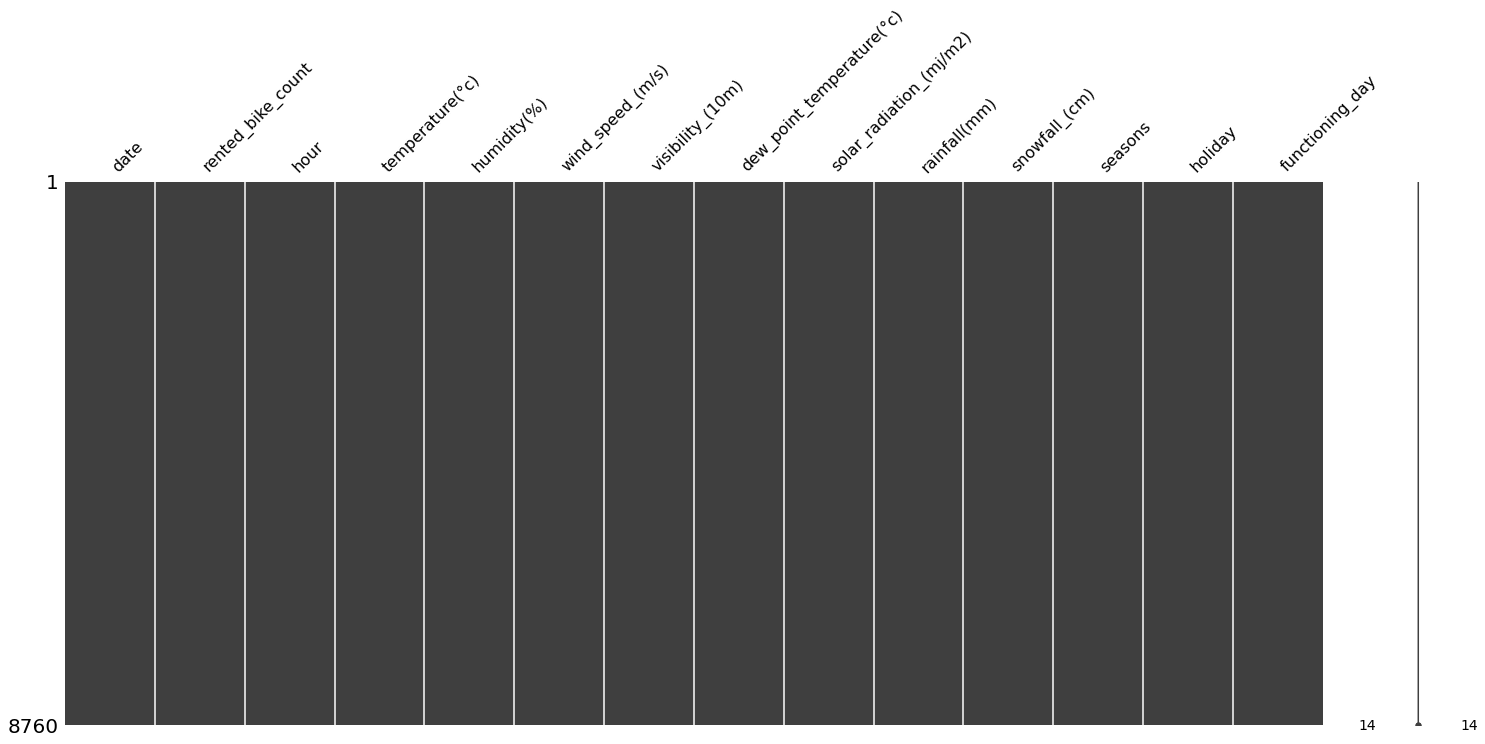

In [12]:
#I could also check it with a missingno library
msno.matrix(df_seoulbike)

## __Checking the data type and casting it if necessary__

In [13]:
#Ok really no missing values
#Let's ckeck the type of columns do we have
df_seoulbike.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date                       8760 non-null   object 
 1   rented_bike_count          8760 non-null   int64  
 2   hour                       8760 non-null   int64  
 3   temperature(°c)            8760 non-null   float64
 4   humidity(%)                8760 non-null   int64  
 5   wind_speed_(m/s)           8760 non-null   float64
 6   visibility_(10m)           8760 non-null   int64  
 7   dew_point_temperature(°c)  8760 non-null   float64
 8   solar_radiation_(mj/m2)    8760 non-null   float64
 9   rainfall(mm)               8760 non-null   float64
 10  snowfall_(cm)              8760 non-null   float64
 11  seasons                    8760 non-null   object 
 12  holiday                    8760 non-null   object 
 13  functioning_day            8760 non-null   objec

In [14]:
df_seoulbike.dtypes

date                          object
rented_bike_count              int64
hour                           int64
temperature(°c)              float64
humidity(%)                    int64
wind_speed_(m/s)             float64
visibility_(10m)               int64
dew_point_temperature(°c)    float64
solar_radiation_(mj/m2)      float64
rainfall(mm)                 float64
snowfall_(cm)                float64
seasons                       object
holiday                       object
functioning_day               object
dtype: object

In [15]:
int_type = df_seoulbike.select_dtypes(include = "integer").columns.to_list()
float_type = df_seoulbike.select_dtypes(include = "float").columns.to_list()
object_type = df_seoulbike.select_dtypes(include = "object").columns.to_list()

print("The int columns type: ")
int_type



The int columns type: 


['rented_bike_count', 'hour', 'humidity(%)', 'visibility_(10m)']

In [16]:
df_seoulbike.select_dtypes(include = "integer")

,rented_bike_count,hour,humidity(%),visibility_(10m)
0,254,0,37,2000
1,204,1,38,2000
2,173,2,39,2000
3,107,3,40,2000
4,78,4,36,2000
...,...,...,...,...
8755,1003,19,34,1894
8756,764,20,37,2000
8757,694,21,39,1968
8758,712,22,41,1859


In [17]:
print("The float columns type: ")
float_type

The float columns type: 


['temperature(°c)',
 'wind_speed_(m/s)',
 'dew_point_temperature(°c)',
 'solar_radiation_(mj/m2)',
 'rainfall(mm)',
 'snowfall_(cm)']

In [18]:
df_seoulbike.select_dtypes(include = "float")

,temperature(°c),wind_speed_(m/s),dew_point_temperature(°c),solar_radiation_(mj/m2),rainfall(mm),snowfall_(cm)
0,-5.2,2.2,-17.6,0.0,0.0,0.0
1,-5.5,0.8,-17.6,0.0,0.0,0.0
2,-6.0,1.0,-17.7,0.0,0.0,0.0
3,-6.2,0.9,-17.6,0.0,0.0,0.0
4,-6.0,2.3,-18.6,0.0,0.0,0.0
...,...,...,...,...,...,...
8755,4.2,2.6,-10.3,0.0,0.0,0.0
8756,3.4,2.3,-9.9,0.0,0.0,0.0
8757,2.6,0.3,-9.9,0.0,0.0,0.0
8758,2.1,1.0,-9.8,0.0,0.0,0.0


In [19]:
print("The object columns type: ")
object_type

The object columns type: 


['date', 'seasons', 'holiday', 'functioning_day']

In [20]:
df_seoulbike.select_dtypes(include = "object")

,date,seasons,holiday,functioning_day
0,01/12/2017,Winter,No Holiday,Yes
1,01/12/2017,Winter,No Holiday,Yes
2,01/12/2017,Winter,No Holiday,Yes
3,01/12/2017,Winter,No Holiday,Yes
4,01/12/2017,Winter,No Holiday,Yes
...,...,...,...,...
8755,30/11/2018,Autumn,No Holiday,Yes
8756,30/11/2018,Autumn,No Holiday,Yes
8757,30/11/2018,Autumn,No Holiday,Yes
8758,30/11/2018,Autumn,No Holiday,Yes


In [21]:
#Hun I'm not sure we need use float64 in all float types. Maybe we can improve it.
#Let's ckeck the usage of all memory.
first_memory_usage = df_seoulbike.memory_usage(deep=True)
first_memory_usage

Index                           128
date                         586920
rented_bike_count             70080
hour                          70080
temperature(°c)               70080
humidity(%)                   70080
wind_speed_(m/s)              70080
visibility_(10m)              70080
dew_point_temperature(°c)     70080
solar_radiation_(mj/m2)       70080
rainfall(mm)                  70080
snowfall_(cm)                 70080
seasons                      551880
holiday                      585624
functioning_day              525305
dtype: int64

#### Ok now we know the type of columns we are working with. Let's casting some of then and create other ones.


In [22]:


class Treating_data:
    '''
    A class to cast the datetypes and to create new columns date type.. 
    Changing the data type, creating new date columns information and changing the new columns date type.
    '''
    
    def __init__(self, df_bike):
        '''
        Creating the sequence of treating to data.
        '''
        self.df_bike = df_bike
        self.changing_type(self.df_bike)
        self.creating_date_info(self.df_bike)
        self.changing_type_after_date_info(self.df_bike)
        self.changing_to_binary_column(self.df_bike)


    def changing_type(self,df_seoulbike):
        '''
        A functon to change the size of float type, 
        to create a column to datetime type and change object type to category type.
        '''
        for coluna in df_seoulbike.columns:
            if "temperature" in coluna:
                df_seoulbike[coluna] = df_seoulbike[coluna].astype("float16")
            elif "date" in coluna:
                df_seoulbike[coluna] = pd.to_datetime(arg=df_seoulbike[coluna],format= "%d/%m/%Y")
            elif coluna in ['seasons','holiday','functioning_day']:
                df_seoulbike[coluna] = df_seoulbike[coluna].astype("category")
        return  df_seoulbike


    def creating_date_info(self,df_seoulbike):
        '''
        A function to create date type columns.
        '''
        df_seoulbike['day_of_week'] =df_seoulbike['date'].dt.day_name() 
        df_seoulbike['year'] = df_seoulbike['date'].dt.year
        df_seoulbike['month'] = df_seoulbike['date'].dt.month #I need this feature to stratify during the train and test moment
        #df_seoulbike['day_of_year'] = df_seoulbike['date'].dt.dayofyear
        df_seoulbike['week_of_year'] = df_seoulbike['date'].dt.isocalendar().week
        #df_seoulbike['month_name'] = df_seoulbike['date'].dt.month_name()
        #df_seoulbike['period_day'] = df_seoulbike['date'].dt.strftime('%a')
        df_seoulbike['month_name'] = df_seoulbike['date'].dt.strftime('%b')
        return  df_seoulbike

    def changing_type_after_date_info(self,df_seoulbike):
        '''
        A function to change as category the columns object types of date 
        '''
        for coluna in df_seoulbike.columns:
            if coluna in ['day_of_week','year','month','week_of_year', 'month_name','hour']:
                df_seoulbike[coluna] = df_seoulbike[coluna].astype("category")
        return  df_seoulbike
    
    def changing_to_binary_column(self,df_seoulbike):
        '''
        A function to turne coluns as binary one
        '''
        df_seoulbike["holiday"] = df_seoulbike["holiday"].map({"No Holiday":0,"Holiday":1})
        df_seoulbike["functioning_day"] = df_seoulbike["functioning_day"].map({"No" : 0, "Yes":1})


In [23]:
df_seoulbike = Treating_data(df_seoulbike)

In [24]:
df_seoulbike.df_bike

,date,rented_bike_count,hour,temperature(°c),humidity(%),wind_speed_(m/s),visibility_(10m),dew_point_temperature(°c),solar_radiation_(mj/m2),rainfall(mm),snowfall_(cm),seasons,holiday,functioning_day,day_of_week,year,month,week_of_year,month_name
0,2017-12-01,254,0,-5.199219,37,2.2,2000,-17.593750,0.0,0.0,0.0,Winter,0,1,Friday,2017,12,48,Dec
1,2017-12-01,204,1,-5.500000,38,0.8,2000,-17.593750,0.0,0.0,0.0,Winter,0,1,Friday,2017,12,48,Dec
2,2017-12-01,173,2,-6.000000,39,1.0,2000,-17.703125,0.0,0.0,0.0,Winter,0,1,Friday,2017,12,48,Dec
3,2017-12-01,107,3,-6.199219,40,0.9,2000,-17.593750,0.0,0.0,0.0,Winter,0,1,Friday,2017,12,48,Dec
4,2017-12-01,78,4,-6.000000,36,2.3,2000,-18.593750,0.0,0.0,0.0,Winter,0,1,Friday,2017,12,48,Dec
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2018-11-30,1003,19,4.199219,34,2.6,1894,-10.296875,0.0,0.0,0.0,Autumn,0,1,Friday,2018,11,48,Nov
8756,2018-11-30,764,20,3.400391,37,2.3,2000,-9.898438,0.0,0.0,0.0,Autumn,0,1,Friday,2018,11,48,Nov
8757,2018-11-30,694,21,2.599609,39,0.3,1968,-9.898438,0.0,0.0,0.0,Autumn,0,1,Friday,2018,11,48,Nov
8758,2018-11-30,712,22,2.099609,41,1.0,1859,-9.796875,0.0,0.0,0.0,Autumn,0,1,Friday,2018,11,48,Nov


In [25]:
df_seoulbike_treated = df_seoulbike.df_bike

In [26]:
df_seoulbike_treated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   date                       8760 non-null   datetime64[ns]
 1   rented_bike_count          8760 non-null   int64         
 2   hour                       8760 non-null   category      
 3   temperature(°c)            8760 non-null   float16       
 4   humidity(%)                8760 non-null   int64         
 5   wind_speed_(m/s)           8760 non-null   float64       
 6   visibility_(10m)           8760 non-null   int64         
 7   dew_point_temperature(°c)  8760 non-null   float16       
 8   solar_radiation_(mj/m2)    8760 non-null   float64       
 9   rainfall(mm)               8760 non-null   float64       
 10  snowfall_(cm)              8760 non-null   float64       
 11  seasons                    8760 non-null   category      
 12  holida

In [27]:
df_seoulbike_treated.describe()

,rented_bike_count,temperature(°c),humidity(%),wind_speed_(m/s),visibility_(10m),dew_point_temperature(°c),solar_radiation_(mj/m2),rainfall(mm),snowfall_(cm)
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,704.602055,inf,58.226256,1.724909,1436.825799,4.074219,0.569111,0.148687,0.075068
std,644.997468,11.945312,20.362413,1.036300,608.298712,13.054688,0.868746,1.128193,0.436746
min,0.000000,-17.796875,0.000000,0.000000,27.000000,-30.593750,0.000000,0.000000,0.000000
25%,191.000000,3.500000,42.000000,0.900000,940.000000,-4.699219,0.000000,0.000000,0.000000
50%,504.500000,13.703125,57.000000,1.500000,1698.000000,5.101562,0.010000,0.000000,0.000000
75%,1065.250000,22.500000,74.000000,2.300000,2000.000000,14.796875,0.930000,0.000000,0.000000
max,3556.000000,39.406250,98.000000,7.400000,2000.000000,27.203125,3.520000,35.000000,8.800000


In [28]:
df_seoulbike_treated.shape

(8760, 19)

In [29]:
df_categorical_columns = df_seoulbike_treated.select_dtypes(include = "category")
df_categorical_columns 

,hour,seasons,holiday,functioning_day,day_of_week,year,month,week_of_year,month_name
0,0,Winter,0,1,Friday,2017,12,48,Dec
1,1,Winter,0,1,Friday,2017,12,48,Dec
2,2,Winter,0,1,Friday,2017,12,48,Dec
3,3,Winter,0,1,Friday,2017,12,48,Dec
4,4,Winter,0,1,Friday,2017,12,48,Dec
...,...,...,...,...,...,...,...,...,...
8755,19,Autumn,0,1,Friday,2018,11,48,Nov
8756,20,Autumn,0,1,Friday,2018,11,48,Nov
8757,21,Autumn,0,1,Friday,2018,11,48,Nov
8758,22,Autumn,0,1,Friday,2018,11,48,Nov


In [30]:
categorical_columns = df_categorical_columns.columns

In [31]:
categorical_columns

Index(['hour', 'seasons', 'holiday', 'functioning_day', 'day_of_week', 'year',
       'month', 'week_of_year', 'month_name'],
      dtype='object')

In [32]:
df_seoulbike_treated

,date,rented_bike_count,hour,temperature(°c),humidity(%),wind_speed_(m/s),visibility_(10m),dew_point_temperature(°c),solar_radiation_(mj/m2),rainfall(mm),snowfall_(cm),seasons,holiday,functioning_day,day_of_week,year,month,week_of_year,month_name
0,2017-12-01,254,0,-5.199219,37,2.2,2000,-17.593750,0.0,0.0,0.0,Winter,0,1,Friday,2017,12,48,Dec
1,2017-12-01,204,1,-5.500000,38,0.8,2000,-17.593750,0.0,0.0,0.0,Winter,0,1,Friday,2017,12,48,Dec
2,2017-12-01,173,2,-6.000000,39,1.0,2000,-17.703125,0.0,0.0,0.0,Winter,0,1,Friday,2017,12,48,Dec
3,2017-12-01,107,3,-6.199219,40,0.9,2000,-17.593750,0.0,0.0,0.0,Winter,0,1,Friday,2017,12,48,Dec
4,2017-12-01,78,4,-6.000000,36,2.3,2000,-18.593750,0.0,0.0,0.0,Winter,0,1,Friday,2017,12,48,Dec
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2018-11-30,1003,19,4.199219,34,2.6,1894,-10.296875,0.0,0.0,0.0,Autumn,0,1,Friday,2018,11,48,Nov
8756,2018-11-30,764,20,3.400391,37,2.3,2000,-9.898438,0.0,0.0,0.0,Autumn,0,1,Friday,2018,11,48,Nov
8757,2018-11-30,694,21,2.599609,39,0.3,1968,-9.898438,0.0,0.0,0.0,Autumn,0,1,Friday,2018,11,48,Nov
8758,2018-11-30,712,22,2.099609,41,1.0,1859,-9.796875,0.0,0.0,0.0,Autumn,0,1,Friday,2018,11,48,Nov


In [33]:
df_seoulbike_treated['year'].unique()

[2017, 2018]
Categories (2, int64): [2017, 2018]

In [34]:
df_seoulbike_treated = df_seoulbike_treated.drop(["date"],axis=1, inplace=False)

In [35]:
#Checking all the columns type
df_seoulbike_treated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   rented_bike_count          8760 non-null   int64   
 1   hour                       8760 non-null   category
 2   temperature(°c)            8760 non-null   float16 
 3   humidity(%)                8760 non-null   int64   
 4   wind_speed_(m/s)           8760 non-null   float64 
 5   visibility_(10m)           8760 non-null   int64   
 6   dew_point_temperature(°c)  8760 non-null   float16 
 7   solar_radiation_(mj/m2)    8760 non-null   float64 
 8   rainfall(mm)               8760 non-null   float64 
 9   snowfall_(cm)              8760 non-null   float64 
 10  seasons                    8760 non-null   category
 11  holiday                    8760 non-null   category
 12  functioning_day            8760 non-null   category
 13  day_of_week                8760 n

## __Exploring the Data__

In [36]:
df_seoulbike_treated.head(7)

,rented_bike_count,hour,temperature(°c),humidity(%),wind_speed_(m/s),visibility_(10m),dew_point_temperature(°c),solar_radiation_(mj/m2),rainfall(mm),snowfall_(cm),seasons,holiday,functioning_day,day_of_week,year,month,week_of_year,month_name
0,254,0,-5.199219,37,2.2,2000,-17.593750,0.0,0.0,0.0,Winter,0,1,Friday,2017,12,48,Dec
1,204,1,-5.500000,38,0.8,2000,-17.593750,0.0,0.0,0.0,Winter,0,1,Friday,2017,12,48,Dec
2,173,2,-6.000000,39,1.0,2000,-17.703125,0.0,0.0,0.0,Winter,0,1,Friday,2017,12,48,Dec
3,107,3,-6.199219,40,0.9,2000,-17.593750,0.0,0.0,0.0,Winter,0,1,Friday,2017,12,48,Dec
4,78,4,-6.000000,36,2.3,2000,-18.593750,0.0,0.0,0.0,Winter,0,1,Friday,2017,12,48,Dec
5,100,5,-6.398438,37,1.5,2000,-18.703125,0.0,0.0,0.0,Winter,0,1,Friday,2017,12,48,Dec
6,181,6,-6.601562,35,1.3,2000,-19.500000,0.0,0.0,0.0,Winter,0,1,Friday,2017,12,48,Dec


In [37]:
df_seoulbike_treated.describe()

,rented_bike_count,temperature(°c),humidity(%),wind_speed_(m/s),visibility_(10m),dew_point_temperature(°c),solar_radiation_(mj/m2),rainfall(mm),snowfall_(cm)
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,704.602055,inf,58.226256,1.724909,1436.825799,4.074219,0.569111,0.148687,0.075068
std,644.997468,11.945312,20.362413,1.036300,608.298712,13.054688,0.868746,1.128193,0.436746
min,0.000000,-17.796875,0.000000,0.000000,27.000000,-30.593750,0.000000,0.000000,0.000000
25%,191.000000,3.500000,42.000000,0.900000,940.000000,-4.699219,0.000000,0.000000,0.000000
50%,504.500000,13.703125,57.000000,1.500000,1698.000000,5.101562,0.010000,0.000000,0.000000
75%,1065.250000,22.500000,74.000000,2.300000,2000.000000,14.796875,0.930000,0.000000,0.000000
max,3556.000000,39.406250,98.000000,7.400000,2000.000000,27.203125,3.520000,35.000000,8.800000


In [6]:
# Import the DeviceCodeLoginAuthentication class to authenticate against Power BI
from powerbiclient.authentication import DeviceCodeLoginAuthentication

# Initiate device authentication
device_auth = DeviceCodeLoginAuthentication()

Performing device flow authentication. Please follow the instructions below.
To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code ECH3N8T9P to authenticate.

Device flow authentication successfully completed.
You are now logged in .

The result should be passed only to trusted code in your notebook.


In [8]:

report_id = "f1d65d72-5b7b-4f17-9913-b4b2593e4e0a"


In [10]:
report = Report(report_id=report_id, auth=device_auth)

report

Report()

In [38]:
df_seoulbike_treated['month_name'].unique()

['Dec', 'Jan', 'Feb', 'Mar', 'Apr', ..., 'Jul', 'Aug', 'Sep', 'Oct', 'Nov']
Length: 12
Categories (12, object): ['Dec', 'Jan', 'Feb', 'Mar', ..., 'Aug', 'Sep', 'Oct', 'Nov']

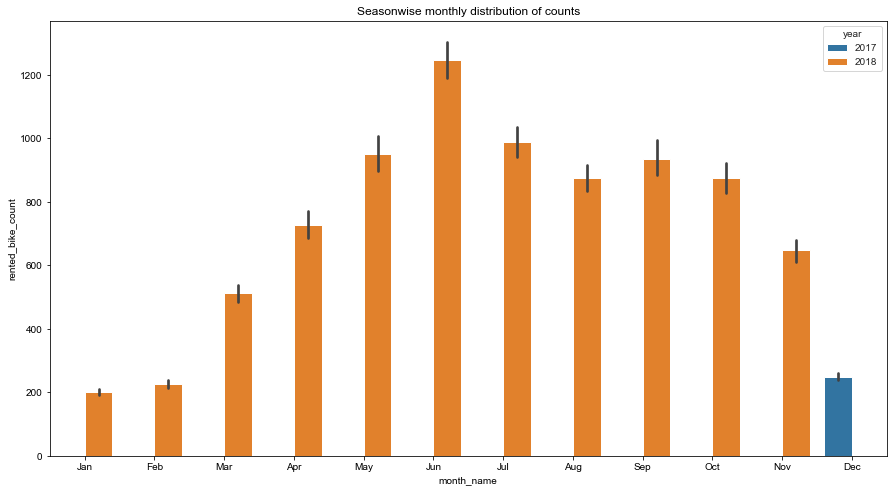

In [39]:
fig,ax=plt.subplots(figsize=(15,8))
sns.set_style('white')
#Bar plot for seasonwise monthly distribution of counts
sns.barplot(x='month_name',y='rented_bike_count',data=df_seoulbike_treated[['month_name','rented_bike_count','year']],hue='year',order=['Jan', 'Feb', 'Mar', 'Apr','May','Jun','Jul', 'Aug', 'Sep', 'Oct', 'Nov','Dec'],ax=ax)
ax.set_title('Seasonwise monthly distribution of counts')
plt.show()

In [ ]:
fig,ax=plt.subplots(figsize=(15,8))
sns.set_style('white')
#Bar plot for seasonwise monthly distribution of counts
sns.barplot(x='month_name',y='rented_bike_count',data=df_seoulbike_treated[['month_name','rented_bike_count','seasons']],hue='seasons',order=['Jan', 'Feb', 'Mar', 'Apr','May','Jun','Jul', 'Aug', 'Sep', 'Oct', 'Nov','Dec'],ax=ax)
ax.set_title('Seasonwise monthly distribution of counts')
plt.show()

In [ ]:


fig,ax=plt.subplots(figsize=(15,8))
sns.set_style('white')
#Bar plot for seasonwise monthly distribution of counts
sns.barplot(x='month_name',y='rainfall(mm)',data=df_seoulbike_treated[['month_name','rainfall(mm)','year']],hue='year',order=['Jan', 'Feb', 'Mar', 'Apr','May','Jun','Jul', 'Aug', 'Sep', 'Oct', 'Nov','Dec'],ax=ax)
ax.set_title('Seasonwise monthly distribution of counts')
plt.show()

In [ ]:

fig,ax=plt.subplots(figsize=(15,8))
sns.set_style('white')
#Bar plot for seasonwise monthly distribution of counts
sns.barplot(x='month_name',y='snowfall_(cm)',data=df_seoulbike_treated[['month_name','snowfall_(cm)','year']],hue='year',order=['Jan', 'Feb', 'Mar', 'Apr','May','Jun','Jul', 'Aug', 'Sep', 'Oct', 'Nov','Dec'],ax=ax)
ax.set_title('Seasonwise monthly distribution of counts')
plt.show()

## Finding Outliers

In [ ]:
celsius = []
for mensure in float_type:
    if '(°c)' in mensure:
        celsius.append(mensure)
fig,ax=plt.subplots(figsize=(15,8))
#Box plot for xxx _outliers
sns.boxplot(data=df_seoulbike_treated[celsius])
ax.set_title('xx_outiers')
plt.show()

In [ ]:

fig,ax=plt.subplots(figsize=(15,8))
#Box plot for xxx _outliers
sns.boxplot(data=df_seoulbike_treated['humidity(%)'])
ax.set_title('xx_outiers')
plt.show()

In [ ]:



fig,ax=plt.subplots(figsize=(15,8))
#Box plot for xxx _outliers
sns.boxplot(data=df_seoulbike_treated['visibility_(10m)'])
ax.set_title('xx_outiers')
plt.show()

In [ ]:


fig,ax=plt.subplots(figsize=(15,8))
#Box plot for xxx _outliers
sns.boxplot(data=df_seoulbike_treated['wind_speed_(m/s)'])
ax.set_title('xx_outiers')
plt.show()

In [ ]:
df_seoulbike_treated['wind_speed_(m/s)'].describe()

In [ ]:
wind_speed_Q1 = df_seoulbike_treated['wind_speed_(m/s)'].quantile(0.25)
wind_speed_Q3 = df_seoulbike_treated['wind_speed_(m/s)'].quantile(0.75)

print(f"The first Quantile of Wind_Speed is {wind_speed_Q1}")
print(f"The Thrid Quantile of Wind_Speed is {wind_speed_Q3}")

In [ ]:
wind_speed_IQR = wind_speed_Q3-wind_speed_Q1
wind_speed_IQR

### Calculating the Mild Outliers

In [ ]:
#Calculating the Mild Outliers

mild_lower_bound = wind_speed_Q1-(1.5 * wind_speed_IQR)
mild_upper_bound = wind_speed_Q3+(1.5 * wind_speed_IQR)
print(f"The Mild Lower Bound is {mild_lower_bound}")
print(f"The Mild Upper Bound is {mild_upper_bound}")

### Calculating the Extreme Outlier


In [ ]:
extreme_lower_bound = wind_speed_Q1-(3 * wind_speed_IQR)
extreme_upper_bound = wind_speed_Q3+(3 * wind_speed_IQR)
print(f"The Extreme Lower Bound is {extreme_lower_bound}")
print(f"The Extreme Upper Bound is {extreme_upper_bound}")

In [ ]:
outliers_lied_upper = df_seoulbike_treated['wind_speed_(m/s)']>mild_upper_bound

In [ ]:
#Now let's determine the number of outlier thar are lie outside of the mild_upper_bound

number_of_outliers_lied_upper=(df_seoulbike_treated['wind_speed_(m/s)']>mild_upper_bound).sum()
number_of_outliers_lied_upper

In [ ]:
#Calculating the percentage of wind_speed lied over the Mild Upper Bound
(df_seoulbike_treated['wind_speed_(m/s)']>mild_upper_bound).mean()*100

In [ ]:
#So now we'll identify which ones they are.
df_seoulbike_treated_wind_speed_lied_upper_outliers= df_seoulbike_treated[df_seoulbike_treated['wind_speed_(m/s)']>mild_upper_bound]
df_seoulbike_treated_wind_speed_lied_upper_outliers

In [ ]:
df_seoulbike_treated_wind_speed_lied_upper_outliers.describe()

In [ ]:
#let's see in which season that happened

fig,ax=plt.subplots(figsize=(15,8))
sns.set_style('white')
#Bar plot for seasonwise monthly distribution of counts
sns.barplot(x='month_name',y='rented_bike_count',data=df_seoulbike_treated_wind_speed_lied_upper_outliers[['month_name','rented_bike_count','seasons']],hue='seasons',order=['Jan', 'Feb', 'Mar', 'Apr','May','Jun','Jul', 'Aug', 'Sep', 'Oct', 'Nov','Dec'],ax=ax)
ax.set_title('Wind Speed Lied over Mild Upper Outliers')
plt.show()

Ok that happened during all the year
OK I will replace the upper outliers with the mean valuers during each season

In [ ]:
media_wind_speed=df_seoulbike_treated_wind_speed_lied_upper_outliers['wind_speed_(m/s)']
media_wind_speed = media_wind_speed.describe().values[1]
media_wind_speed

In [ ]:
df_seoulbike_treated_wind_speed_lied_upper_outliers_teste =df_seoulbike_treated_wind_speed_lied_upper_outliers.copy()

In [ ]:


df_seoulbike_treated['wind_speed_(m/s)'] = np.where(df_seoulbike_treated['wind_speed_(m/s)']>mild_upper_bound,mild_upper_bound,df_seoulbike_treated['wind_speed_(m/s)'])

In [ ]:
df_seoulbike_treated_wind_speed_lied_upper_outliers_teste['wind_speed_(m/s)']

In [ ]:
df_seoulbike_treated.describe()

In [ ]:
df_seoulbike_treated_wind_speed_lied_upper_outliers.iloc[82,4]

In [ ]:
df_seoulbike_treated.iloc[82,4]

In [ ]:


fig,ax=plt.subplots(figsize=(15,8))
#Box plot for xxx _outliers
sns.boxplot(data=df_seoulbike_treated['solar_radiation_(mj/m2)'])
ax.set_title('xx_outiers')
plt.show()

In [ ]:
df_seoulbike_treated.info()

### df_seoulbike_treated

In [ ]:
solar_radiation_Q1 = df_seoulbike_treated['solar_radiation_(mj/m2)'].quantile(0.25)
solar_radiation_Q3 = df_seoulbike_treated['solar_radiation_(mj/m2)'].quantile(0.75)

print(f"The first Quantile of solar_radiation_(mj/m2) is {solar_radiation_Q1}")
print(f"The Thrid Quantile of solar_radiation_(mj/m2) is {solar_radiation_Q3}")

In [ ]:
solar_radiation_IQR = solar_radiation_Q3-solar_radiation_Q1
solar_radiation_IQR



### Calculating the Mild Outliers

In [ ]:
#Calculating the Mild Outliers

solar_mild_lower_bound = solar_radiation_Q1-(1.5 * solar_radiation_IQR)
solar_mild_upper_bound = solar_radiation_Q3+(1.5 * solar_radiation_IQR)
print(f"The Mild Lower Bound is {solar_mild_lower_bound}")
print(f"The Mild Upper Bound is {solar_mild_upper_bound}")

### Calculating the Extreme Outlier


In [ ]:
extreme_solar_lower_bound = solar_radiation_Q1-(3 * solar_radiation_IQR)
extreme_solar_upper_bound = solar_radiation_Q1+(3 * solar_radiation_IQR)
print(f"The Extreme Lower Bound is {extreme_lower_bound}")
print(f"The Extreme Upper Bound is {extreme_upper_bound}")

In [ ]:
solar_radiation_outliers_lied_upper = df_seoulbike_treated['solar_radiation_(mj/m2)']>solar_mild_upper_bound

In [ ]:
#Now let's determine the number of outlier thar are lie outside of the mild_upper_bound

number_of_solar_radiation_outliers_lied_upper=solar_radiation_outliers_lied_upper.sum()
number_of_solar_radiation_outliers_lied_upper

In [ ]:
#Calculating the percentage of wind_speed lied over the Mild Upper Bound
(df_seoulbike_treated['solar_radiation_(mj/m2)']>solar_mild_upper_bound).mean()*100

Wow!!! It's a lot and represent 7% of the data...

In [ ]:
#So now we'll identify which ones they are.
df_seoulbike_treated_solar_radiation_lied_upper_outliers= df_seoulbike_treated[df_seoulbike_treated['solar_radiation_(mj/m2)']>solar_mild_upper_bound]
df_seoulbike_treated_solar_radiation_lied_upper_outliers

In [ ]:
#OK I will replace with the upper bound value

df_seoulbike_treated['solar_radiation_(mj/m2)'] = np.where(df_seoulbike_treated['solar_radiation_(mj/m2)']>solar_mild_upper_bound,solar_mild_upper_bound,df_seoulbike_treated['solar_radiation_(mj/m2)'])

In [ ]:
df_seoulbike_treated['snowfall_(cm)'].describe()

In [ ]:
#from sklearn.model_selection import train_test_split
target_y = df_seoulbike_treated["rented_bike_count"]
features_x = df_seoulbike_treated.drop("rented_bike_count",axis=1, inplace=False)
train_x,test_x, train_y,test_y = train_test_split(features_x, target_y, test_size=0.2, stratify=features_x['month'].to_numpy(), shuffle = True)

#### The scikit-learn does not provide any support for variable selection using a forward selection approach.   We will write a custom class for that. page 108

In [ ]:
from sklearn.base import BaseEstimator
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.sparse import csr_matrix
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

###incluir CategoricalVaribleEncoder class from page 53 of pragmatic Machine Learning
class CategoricalVaribleEncoder(BaseEstimator): #page 53
    
    def __init__(self,categorical_features):
        self.categorical_features = categorical_features
        self.preprocessing_transformer = make_column_transformer((OneHotEncoder(handle_unknown="ignore"),
                                                                 self.categorical_features))
        
    def fit(self, X, y=None):
        self.preprocessing_transformer.fit(X)
        return self
        
    def transform(self, X):
        preprocessed_x = self.preprocessing_transformer.transform(X)
        return csr_matrix(preprocessed_x).todense()





class FowardSelectionLinearRegression(BaseEstimator): #page 108
    
    def __init__(self):
        self.optimal_predictors = None
        self.optimal_model = None
        
    def fit(self, X,y=None):
        current_predictors = []
        if not isinstance(X,pd.DataFrame):
            X = pd.DataFrame(X)
        remaining_predictors = list(X)
        adjusted_r2_diff = 1
        last_adjusted_r2 = 0
        
        while True:
            best_predictor, adjusted_r2, r2 = self._get_next_best_predictor_(X=X, Y=y, current_predictors = current_predictors,
                                                                           remaining_predictors = remaining_predictors)
            adjusted_r2_diff = round(adjusted_r2 - last_adjusted_r2, 2)
            if adjusted_r2_diff <= 0.00 or len(remaining_predictors) <= 0:
                break
                
            current_predictors.append(best_predictor)
            remaining_predictors.remove(best_predictor)
            last_adjusted_r2 = adjusted_r2
            
        self.optimal_predictors_ = current_predictors
        self.optimal_model_ = LinearRegression().fit(X[self.optimal_predictors_],y)
        
    def _adjusted_r2_score_(self, r2_val, n, k):
        return (1-(((1-r2_val)*(n-1))/(n-k-1)))
    
    def _get_next_best_predictor_(self, X, Y, current_predictors=None, remaining_predictors=None):
        max_adjusted_r2_val = 0
        adjusted_r2_val = 0
        best_r2_val = 0
        r2Val = 0
        best_predictor = None
        n = len(X)
        
        for predictor in remaining_predictors:
            lr = LinearRegression()
            
            predictors = []
            predictors.extend(current_predictors)
            predictors.append(predictor)
            
            lr.fit(X[predictors],Y)
            predY = lr.predict(X[predictors])
            r2Val = r2_score(Y,predY)
            adjusted_r2_val = self._adjusted_r2_score_(r2Val, n,len(predictors))
            if max_adjusted_r2_val < adjusted_r2_val:
                best_predictor = predictor
                max_adjusted_r2_val = adjusted_r2_val
                best_r2_val = r2Val
                
        return best_predictor, max_adjusted_r2_val, best_r2_val
    
    def predict(self, X):
        if not isinstance(X,pd.DataFrame):
            X = pd.DataFrame(X)
        X = X[self.optimal_predictors_]
        return self.optimal_model_.predict(X)
    

# Building the Model

### Foward Selection Linear Regression

In [ ]:
fs_lr = FowardSelectionLinearRegression()

bike_seoul_pl = Pipeline(steps = [('one_hot_encoder', CategoricalVaribleEncoder(categorical_features = categorical_columns)),
        ('scaler',StandardScaler()),
        ('foward_selection_model',fs_lr)
        
    ]
)
    
bike_seoul_pl.fit(train_x,train_y)
        

In [ ]:
## page 110 to see the best predictors
list(df_seoulbike_treated.loc[fs_lr.optimal_predictors_])

In [ ]:
len(list(df_seoulbike_treated.loc[fs_lr.optimal_predictors_]))

In [ ]:
df_seoulbike_treated.shape

In [ ]:
test_bike_seoul_pl_y = bike_seoul_pl.predict(test_x)


In [ ]:
type(test_y)

In [ ]:
type(test_bike_seoul_pl_y)

In [ ]:
test_bike_seoul_pl_y_list = list(test_bike_seoul_pl_y)

In [ ]:
len(test_bike_seoul_pl_y_list)

In [ ]:
len(list(test_y))

In [ ]:
r_2 = r2_score(list(test_y), test_bike_seoul_pl_y_list)

In [ ]:
r_2

In [ ]:
test_bike_seoul_pl_y.max(axis=0)

In [ ]:
test_bike_seoul_pl_y.min(axis=0)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

# The coefficients
#print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(list(test_y), test_bike_seoul_pl_y_list))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(list(test_y), test_bike_seoul_pl_y_list))

In [ ]:
houra_zero = (test_x['hour']==0).sum()

In [ ]:
houra_zero

In [ ]:
test_x['year'].unique()

In [ ]:
# Plot outputs
plt.scatter(test_x['hour'][1:10].to_numpy(), test_y[1:10], color="black")
plt.plot(test_x['hour'][1:10].to_numpy(), test_bike_seoul_pl_y[1:10],color="blue", linewidth=1)

#plt.xticks(())
#plt.yticks(())

plt.show()

In [ ]:
import seaborn as sns
residuals = test_bike_seoul_pl_y- test_y
sns.scatterplot(data = residuals)
plt.xlabel("Data Instance")
plt.ylabel("Residual")
plt.show()



### Polynomial Regression

In [ ]:
class PolynomialRegression(BaseEstimator):
    '''
    '''
    def __init__(self, degree=2):
        self.degree = degree
        self.poly_reg_model = LinearRegression()
        
    def _generate_polynomial_features_(self, X):
        '''
        '''
        new_columns = []
        columns = list(X)
        for c in columns:
            for d in range(2, (self.degree+1)):
                new_c = str(c)+"^"+str(d)
                X[new_c]=pow(X[c],d)
        return X

    def fit(self, X, y=None):
        '''
        '''
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        X = self._generate_polynomial_features_(X)
        self.poly_reg_model.fit(X,y)
        
    def predict(self, X):
        '''
        '''
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        X = self._generate_polynomial_features_(X)
        return self.poly_reg_model.predict(X)
            

In [ ]:
poly_reg = PolynomialRegression(degree=11)
poly_lr_pl = Pipeline(steps = [('one_hot_encoder', CategoricalVaribleEncoder(categorical_features = categorical_columns)),
        ('scaler',StandardScaler()),
        ('poly_reg',poly_reg)
        
    ]
)

poly_lr_pl.fit(train_x,train_y)

In [ ]:
predited_poly_y = poly_lr_pl.predict(test_x)

In [ ]:
predited_poly_y

In [ ]:
test_y.to_numpy()

In [ ]:
r2_score(test_y.to_numpy(),predited_poly_y)

In [ ]:
train_predited_poly_y = poly_lr_pl.predict(train_x)

In [ ]:
r2_score(train_y.to_numpy(),train_predited_poly_y)

In [ ]:
# Plot outputs
plt.scatter((test_x['hour'][1:10]).to_numpy(), test_y[1:10], color="black")
plt.plot((test_x['hour'][1:10]).to_numpy(), test_bike_seoul_pl_y[1:10], color="blue", linewidth=1)

plt.xticks(())
plt.yticks(())

plt.show()

In [ ]:
#We have a problem of overfitting here as explained in page 118

## Lasso

In [ ]:
from sklearn.linear_model import Lasso

lasso_model = Lasso()
lasso_bike_model_pl = Pipeline(steps = [('one_hot_encoder', CategoricalVaribleEncoder(categorical_features = categorical_columns)),
        ('scaler',StandardScaler()),
        ('lr',lasso_model)
        
    ]
)
lasso_bike_model_pl.fit(train_x,train_y)


In [ ]:
test_lasso_bike_y = lasso_bike_model_pl.predict(test_x)


In [ ]:
test_lasso_bike_y

In [ ]:
test_y

In [ ]:
r2_score(test_y.to_numpy(),test_lasso_bike_y)

In [ ]:
# Plot outputs
plt.scatter(list(test_x['hour'][1:10]), test_y[1:10], color="black")
plt.plot(list(test_x['hour'][1:10]), test_lasso_bike_y[1:10], color="blue", linewidth=1)

plt.xticks(())
plt.yticks(())

plt.show()

## DecisionTreeRegressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor

dt_bike_reg = DecisionTreeRegressor()
dt_bike_reg_pl = Pipeline(steps = [('one_hot_encoder', CategoricalVaribleEncoder(categorical_features = categorical_columns)),
        ('scaler',StandardScaler()),
        ('dt_reg',dt_bike_reg)
        
    ]
)

dt_bike_reg_pl.fit(train_x,train_y)

In [ ]:
predicted_bike_dt_reg_y =dt_bike_reg_pl.predict(test_x)
r2_score(test_y,predicted_bike_dt_reg_y)

In [ ]:
# Plot outputs
plt.scatter(list(test_x['hour'][1:10]), test_y[1:10], color="black")
plt.plot(list(test_x['hour'][1:10]), predicted_bike_dt_reg_y[1:10], color="blue", linewidth=1)

plt.xticks(())
plt.yticks(())

plt.show()

## SVM

In [ ]:


from sklearn.svm import LinearSVR

bike_svm_reg = LinearSVR(1.5)
bike_svm_reg_pl = Pipeline(steps = [('one_hot_encoder', CategoricalVaribleEncoder(categorical_features = categorical_columns)),
        ('scaler',StandardScaler()),
        ('SVM_reg',bike_svm_reg)
        
    ]
)

bike_svm_reg_pl.fit(train_x,train_y)

In [ ]:
predicted_bike_dt_svm_y =bike_svm_reg_pl.predict(test_x)
r2_score(test_y.to_numpy(),predicted_bike_dt_svm_y)

In [ ]:
test_y

In [ ]:
predicted_bike_dt_svm_y

In [ ]:
# Plot outputs
plt.scatter(test_x['hour'][1:10].to_numpy(), test_y[1:10], color="black")
plt.plot(test_x['hour'][1:10].to_numpy(), predicted_bike_dt_svm_y[1:10], color="blue", linewidth=1)

plt.xticks(())
plt.yticks(())

plt.show()

In [ ]:
from sklearn.svm import SVR

bike_svm_reg_2 = SVR(kernel="poly", degree=2, C=100, epsilon=0.1)
bike_svm_reg_pl_2 = Pipeline(steps = [('one_hot_encoder', CategoricalVaribleEncoder(categorical_features = categorical_columns)),
        ('scaler',StandardScaler()),
        ('SVM_reg_2',bike_svm_reg_2)
        
    ]
)

bike_svm_reg_pl_2.fit(train_x,train_y)

In [ ]:
predicted_bike_dt_svm_y_2 =bike_svm_reg_pl_2.predict(test_x)
r2_score(test_y.to_numpy(),predicted_bike_dt_svm_y_2)

In [ ]:
# Plot outputs
plt.scatter(test_x['hour'][1:10].to_numpy(), test_y[1:10], color="black")
plt.plot(test_x['hour'][1:10].to_numpy(), predicted_bike_dt_svm_y_2[1:10], color="blue", linewidth=1)

plt.xticks(())
plt.yticks(())

plt.show()

#### To do not affect the accuracy and also to not increase the complexity of our model unnecessary,we will chose the best features to work with.  
#### Building the Adjusted R2
 but the model R2 does not improve that much. It indicates the fact that some features may be irrelevant and are not influencing the determination of target variable value. Those can be excluded while building the final model. Adjusted R2